In [5]:
!nvidia-smi

Wed Jul 27 16:38:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   44C    P8     3W /  N/A |      7MiB /  3911MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import statements

In [6]:
from torchvision import datasets
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torchvision.utils import make_grid

In [32]:
%matplotlib inlinena

# Configuration

In [8]:
config = dict(
    num_workers=0,
    batch_size=64,
    input_size=784,
    d_output_size=1,
    d_hidden_size=32,
    z_size=100,
    g_output_size=784,
    g_hidden_size=32,
    lr=0.002,
    num_epochs=100,
    sample_size=16,
    image_size=(28, 28),
    device='cuda'
)

# Dataset

In [9]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(
    root='.pytorch/MNIST/',
    train=True,
    download=True,
    transform=transform)
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=config['batch_size'],
    num_workers=config['num_workers']
)

## Visualizing the Dataset

In [10]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
img = np.squeeze(images[0])
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
fig.show()

<IPython.core.display.Javascript object>

# Network

## Discriminator

In [11]:
disc_dims = [4, 2, 1]


class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size, negative_slope=0.2, dropout_probability=0.3):
        super(Discriminator, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        self.input_size = input_size
        self.features = self._make_layers(negative_slope, dropout_probability)
        self.classifier = nn.Linear(self.hidden_dim, output_size)

    def _make_layers(self, negative_slope, dropout_probability):
        layers = []
        in_channels = self.input_size
        for layer in disc_dims:
            layers += [
                nn.Linear(in_channels, self.hidden_dim*layer),
                nn.LeakyReLU(negative_slope=negative_slope),
                nn.Dropout(p=dropout_probability),
            ]
            in_channels = self.hidden_dim*layer
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


## Generator

In [12]:
gen_dims = [4, 2, 1]


class Generator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size, negative_slope=0.2, dropout_probability=0.3):
        super(Generator, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        self.input_size = input_size
        self.features = self._make_layers(negative_slope, dropout_probability)

    def _make_layers(self, negative_slope, dropout_probability):
        layers = []
        in_channels = self.input_size
        for layer in disc_dims:
            layers += [
                nn.Linear(in_channels, self.hidden_dim*layer),
                nn.LeakyReLU(negative_slope=negative_slope),
                nn.Dropout(p=dropout_probability),
            ]
            in_channels = self.hidden_dim*layer
        layers += [
            nn.Linear(self.hidden_dim, self.output_size),
            nn.Tanh()
        ]
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.features(x)

## Network Initialization

In [13]:
D = Discriminator(config['input_size'], hidden_dim=config['d_hidden_size'], output_size=config['d_output_size']).to(
    config['device'])
G = Generator(config['z_size'], hidden_dim=config['g_hidden_size'], output_size=config['g_output_size']).to(
    config['device'])

In [14]:
summary(D, (1, config['input_size']), col_names=["input_size", "output_size", "kernel_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Kernel Shape              Param #
Discriminator                            [1, 784]                  [1, 1]                    --                        --
├─Sequential: 1-1                        [1, 784]                  [1, 32]                   --                        --
│    └─Linear: 2-1                       [1, 784]                  [1, 128]                  --                        100,480
│    └─LeakyReLU: 2-2                    [1, 128]                  [1, 128]                  --                        --
│    └─Dropout: 2-3                      [1, 128]                  [1, 128]                  --                        --
│    └─Linear: 2-4                       [1, 128]                  [1, 64]                   --                        8,256
│    └─LeakyReLU: 2-5                    [1, 64]                   [1, 64]                   --                        --
│    └─Drop

In [15]:
summary(G, (1, config['z_size']), col_names=["input_size", "output_size", "kernel_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Kernel Shape              Param #
Generator                                [1, 100]                  [1, 784]                  --                        --
├─Sequential: 1-1                        [1, 100]                  [1, 784]                  --                        --
│    └─Linear: 2-1                       [1, 100]                  [1, 128]                  --                        12,928
│    └─LeakyReLU: 2-2                    [1, 128]                  [1, 128]                  --                        --
│    └─Dropout: 2-3                      [1, 128]                  [1, 128]                  --                        --
│    └─Linear: 2-4                       [1, 128]                  [1, 64]                   --                        8,256
│    └─LeakyReLU: 2-5                    [1, 64]                   [1, 64]                   --                        --
│    └─Dropo

# Losses

In [16]:
def real_loss(D_out, criterion, smooth=False):
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size, device=config['device'])*0.9
    else:
        labels = torch.ones(batch_size, device=config['device'])
    criterion = nn.BCEWithLogitsLoss()

    loss = criterion(D_out.squeeze(), labels)
    return loss


def fake_loss(D_out, criterion):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size, device=config['device'])

    loss = criterion(D_out.squeeze(), labels)
    return loss

# Optimizer

In [17]:
d_optimizer = optim.Adam(D.parameters(), config['lr'])
g_optimizer = optim.Adam(G.parameters(), config['lr'])
criterion = nn.BCEWithLogitsLoss()

# Training

In [18]:
sample_z = torch.empty(config['batch_size'], config['z_size'], device=config['device']).uniform_(-1, 1)
D.train()
G.train()

Generator(
  (features): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=32, out_features=784, bias=True)
    (10): Tanh()
  )
)

In [19]:
losses = []
grids = []


def train(num_epochs, print_every):
    for epoch in (pbar := tqdm(range(num_epochs), position=0)):
        for batch_i, (real_images, _) in tqdm(enumerate(train_loader), position=0, leave=False):
            real_images = real_images.to(config['device'])
            batch_size = real_images.size(0)

            real_images = real_images.permute([1, 0, 2, 3])
            real_images = real_images.squeeze()
            real_images = real_images.reshape(batch_size, -1)
            real_images = real_images*(1 - (-1)) - 1  # scale to -1, 1

            d_optimizer.zero_grad()
            d_real_images = D(real_images)
            d_real_images_loss = real_loss(d_real_images, criterion, smooth=True)

            z = torch.empty(batch_size, config['z_size'], device=config['device']).uniform_(-1, 1)
            fake_images = G(z)

            d_fake_images = D(fake_images)
            d_fake_images_loss = fake_loss(d_fake_images, criterion)

            d_loss = d_real_images_loss + d_fake_images_loss
            d_loss.backward()
            d_optimizer.step()

            g_optimizer.zero_grad()
            z = torch.empty(batch_size, config['z_size'], device=config['device']).uniform_(-1, 1)
            fake_images = G(z)
            d_fake = D(fake_images)
            g_loss = real_loss(d_fake, criterion)  # real loss function as flipped labels

            g_loss.backward()
            g_optimizer.step()

            if batch_i%print_every==0:
                pbar.set_description(
                    f'Epoch [{epoch:5d}/{num_epochs:5d}] | d_loss: {d_loss.item():6.4f} | g_loss: {g_loss.item():6.4f}'
                )

        losses.append((g_loss.item(), d_loss.item()))

        G.eval()
        samples = G(sample_z)
        samples = samples.reshape(config['batch_size'], 1, config['image_size'][0], config['image_size'][1])
        grid = make_grid(samples)
        grids.append(grid)

        G.train()


train(config['num_epochs'], 400)

  0%|          | 0/100 [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

KeyboardInterrupt: 

## Training Loss

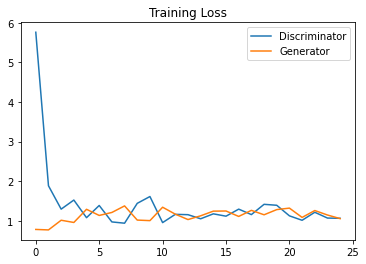

In [33]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Loss")
plt.legend()
plt.show()

# Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


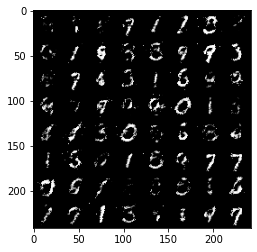

In [37]:
# fix, axs = plt.subplots(50, 2, figsize=[4, 100])
# axs= axs.flatten()
# for i, ax  in zip(grids, axs):
#     ax.imshow(i.cpu().permute([1, 2, 0]))
plt.imshow(grids[-1].cpu().permute(1, 2, 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


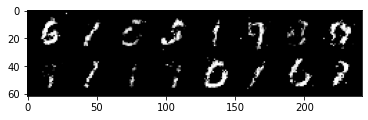

In [40]:
new_rand = torch.empty((config['sample_size'],config['z_size']), device=config['device']).uniform_(-1, 1)
G.eval()

rand_images = G(new_rand)

rand_images = rand_images.reshape(config['sample_size'], 1, config['image_size'][0], config['image_size'][1])
grid = make_grid(rand_images)
plt.imshow(grid.cpu().permute([1, 2, 0]))
plt.show()